In [471]:
import pandas as pd
import numpy as np
import json
import sklearn.impute as impute
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as pl

In [472]:
class DLRFC:
    selection_model = None
    selection_model_1 = None
    rfc1 = RandomForestClassifier(criterion='gini',
                                  max_depth=17,
                                  n_estimators=208,
                                  max_features='sqrt',
                                  min_samples_split=20,
                                  class_weight='balanced',
                                  random_state=42,
                                  oob_score=True,
                                  min_samples_leaf=10,
                                  n_jobs=-1)

    rfc2 = RandomForestClassifier(criterion='gini',
                                  max_depth=17,
                                  n_estimators=200,
                                  max_features='sqrt',
                                  min_samples_split=20,
                                  class_weight='balanced',
                                  random_state=42,
                                  oob_score=True,
                                  min_samples_leaf=10,
                                  n_jobs=-1)

    def data_load(self, path):
        df = pd.read_csv(path)
        sample_id = df['sample_id'].values
        features = df.loc[:, 'feature0':'feature106'].values
        label = df['label'].values
        return sample_id, features, label

    def data_load_test(self, path):
        df = pd.read_csv(path)
        sample_id = df['sample_id'].values
        features = df.loc[:, 'feature0':'feature106'].values
        return sample_id, features

    def train_pre_process(self, X, y, threshold):
        imputer = impute.SimpleImputer(strategy="most_frequent")
        imputer.fit(X)
        X = imputer.transform(X)
        clf = ExtraTreesClassifier(n_estimators=70, n_jobs=-1, random_state=42)
        clf = clf.fit(X, y)
        selection_model = SelectFromModel(clf, prefit=True, threshold=threshold)
        X = selection_model.transform(X)
        return X, y, selection_model

    def valid_pre_process(self, X, selection_model):
        imputer = impute.SimpleImputer(strategy="most_frequent")
        imputer.fit(X)
        X = imputer.transform(X)
        X = selection_model.transform(X)
        return X

    def plot_matrix(self, y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
        cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'))
        pl.colorbar()

        if title is not None:
            pl.title(title)
        num_local = np.array(range(len(labels_name)))
        if axis_labels is None:
            axis_labels = labels_name
        pl.xticks(num_local, axis_labels)
        pl.yticks(num_local, axis_labels)
        pl.ylabel('True label')
        pl.xlabel('Predicted label')

        for i in range(np.shape(cm)[0]):
            for j in range(np.shape(cm)[1]):
                if int(cm[i][j] * 100 + 0.5) > 0:
                    pl.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                            ha="center", va="center",
                            color="white" if cm[i][j] > thresh else "black")
        pl.show()

    def train(self, path):
        sample_id, features, label = self.data_load(path)
        X_train, y_train, self.selection_model = self.train_pre_process(features, label, '1.7*mean')
        self.rfc1.fit(X_train, y_train)

        # 1 2训练集
        category_filter_t = np.isin(label, [1, 2])  # 过滤器
        X_filtered = features[category_filter_t]
        y_filtered = label[category_filter_t]

        if np.sum(category_filter_t) > 0:
            X_train_1, y_train_1, self.selection_model_1 = self.train_pre_process(X_filtered, y_filtered, '1.8*mean')
            self.rfc2.fit(X_train_1, y_train_1)

    def validate(self, path):
        sample_id_v, features_v, label_v = self.data_load(path)
        X_valid = self.valid_pre_process(features_v, self.selection_model)
        X_valid_1 = self.valid_pre_process(features_v, self.selection_model_1)
        y_true = label_v
        y_pred = self.rfc1.predict(X_valid)

        # 使用布尔索引选择预测结果为1或2的数据
        category_filter_v = np.isin(y_pred, [1, 2])
        X_valid_2 = X_valid_1[category_filter_v]

        if np.sum(category_filter_v) > 0:
            y_pred_2 = self.rfc2.predict(X_valid_2)
            y_pred[category_filter_v] = y_pred_2  # 将重新预测的结果赋值给对应的位置

        # y_pred.json
        # y_pred_dict = {str(index): int(value) for index, value in enumerate(y_pred)}
        # json_data = json.dumps(y_pred_dict)
        # with open("../data_new/y_pred.json", "w") as file:
        #     file.write(json_data)

        print(metrics.classification_report(y_pred, y_true))  # 打印报告，这种字符串需要返回给前端
        self.plot_matrix(y_true, y_pred, [0, 1, 2, 3, 4, 5], title='confusion_matrix',
                         axis_labels=['0', '1', '2', '3', '4', '5'])

    def test(self, path):
        sample_id_v, features_v = self.data_load_test(path)
        X_test = self.valid_pre_process(features_v, self.selection_model)
        X_test_1 = self.valid_pre_process(features_v, self.selection_model_1)
        y_pred = self.rfc1.predict(X_test)

        category_filter_t = np.isin(y_pred, [1, 2])
        X_test_2 = X_test_1[category_filter_t]

        if np.sum(category_filter_t) > 0:
            y_pred_2 = self.rfc2.predict(X_test_2)
            y_pred[category_filter_t] = y_pred_2

        unique_labels = set(y_pred)
        counts = [sum(y_pred == label) for label in unique_labels]  # 计算每个分类的样本数量
        labels = [f"Class {label}" for label in unique_labels]  # 创建分类标签的字符串列表
        colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']

        # 绘制分类结果饼状图
        def autopct_format(value):
            return f'{value:.1f}% ({int(value * sum(counts) / 100)})'

        pl.title("Classification Result")
        pl.pie(x=counts, labels=labels, colors=colors, autopct=autopct_format)
        pl.axis('equal')  # 设置纵横比为相等
        pl.show()

In [473]:
dlrfc = DLRFC()
dlrfc.train("../data_new/train_10000.csv")

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       194
           1       0.81      0.83      0.82       162
           2       0.72      0.77      0.75       159
           3       0.98      0.99      0.99       168
           4       0.99      0.94      0.97       165
           5       0.93      0.99      0.96       152

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



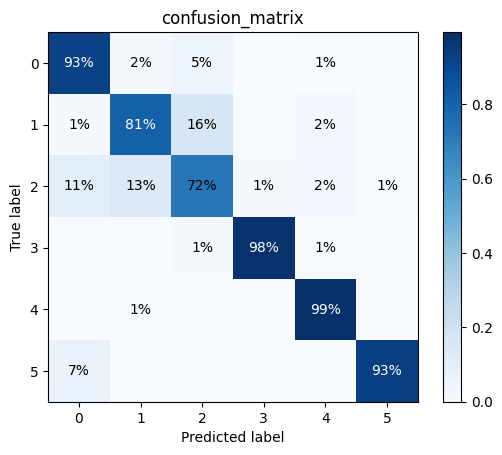

In [474]:
dlrfc.validate("../data_new/validate_1000.csv")

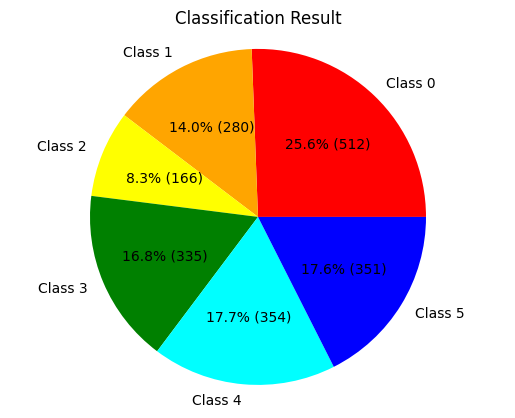

In [475]:
dlrfc.test('../data_new/test_2000_x.csv')